# Spine Segmentation

In [1]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
import cv2
import os
import pydicom
import json

import tensorflow as tf
from tensorflow import keras
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint

2024-02-04 03:13:44.894021: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 03:13:44.962332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 03:13:44.962408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 03:13:44.964327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 03:13:44.975341: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 03:13:44.976181: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Init global variables
DATA_DIR = os.path.abspath('../Data/spine-segmentation')
with open(os.path.join(DATA_DIR, 'files_routes.json'), 'r') as f:
    FILE_DIRS = json.loads(f.read())

RESULTS = os.path.abspath('../Results')

IMG_SHAPE = (576, 240)
VALIDATION_NUM = 6
BATCH_SIZE = 3

WEIGHTS2LOAD = None #os.path.join(RESULTS, 'saved_weights/0-weights_unetpp.hdf5')

## DataSet

In [3]:
class Data_train_generator(Sequence):
    def __init__(self, x_files_list: list, y_files_list: list, batch_size: int, new_image_size = None, shuffle = True) -> None:
        self.data = x_files_list
        self.labels = y_files_list
        self.batch_size = batch_size

        self.shuffle = shuffle
        self.new_image_size = new_image_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __open_png_y(self, file_path):
        img = cv2.imread(file_path)
        img = cv2.inRange(img, (20, 20, 210), (40, 40, 240))
        
        data = np.array(img, dtype="float32") / 255

        if self.new_image_size != None:
            side_pad = (
                int((self.new_image_size[0] - data.shape[0]) / 2),
                int((self.new_image_size[1] - data.shape[1]) / 2)
            )
            data = np.pad(data, (
                (side_pad[0], side_pad[0]),
                (side_pad[1], side_pad[1]),
            ), 'constant', constant_values=0)

        return np.reshape(data, (*self.new_image_size, 1))

    def __open_dcm_x(self, file_path):
        dcm = pydicom.dcmread(file_path)

        data = dcm.pixel_array.astype("float32") / 255

        if self.new_image_size != None:
            side_pad = (
                int((self.new_image_size[0] - data.shape[0]) / 2),
                int((self.new_image_size[1] - data.shape[1]) / 2)
            )
            data = np.pad(data, (
                (side_pad[0], side_pad[0]),
                (side_pad[1], side_pad[1]),
            ), 'constant', constant_values=0)

        return np.reshape(data, (*self.new_image_size, 1))

    def __getitem__(self, index):
        batch_x = np.array(list(map(self.__open_dcm_x, self.data[index * self.batch_size: (index + 1) * self.batch_size])))
        batch_y = np.array(list(map(self.__open_png_y, self.labels[index * self.batch_size: (index + 1) * self.batch_size])))

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            for i in range(len(self.data)):
                ind_from, ind_to = randint(0, len(self.data) - 1), randint(0, len(self.data) - 1)
                self.data[ind_from], self.data[ind_to] = self.data[ind_to], self.data[ind_from]
                self.labels[ind_from], self.labels[ind_to] = self.labels[ind_to], self.labels[ind_from]

## Training And Validating

In [4]:
# training
def make_combine_loss(smooth=1e-6, gama=2): # Actually bin_cross_entropy + dice losses
    def comb_loss(y_true, y_pred):
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, dtype=tf.float32)

        nominator = 2 * tf.multiply(y_pred, y_true) + smooth
        denominator = (y_pred ** gama) + (y_true ** gama) + smooth
        dice_coef = tf.divide(nominator, denominator)

        cross_ent_coef = 0.5 * (tf.multiply(y_true, tf.math.log(y_pred + smooth)) + tf.multiply(1 - y_true, tf.math.log(1 - y_pred + smooth)))

        return tf.reduce_sum(1 - (cross_ent_coef + dice_coef))
    return comb_loss

combine_loss = make_combine_loss()

data_gen = Data_train_generator(FILE_DIRS["dicom"][:-VALIDATION_NUM], FILE_DIRS["converted"][:-VALIDATION_NUM], BATCH_SIZE, IMG_SHAPE)
val_gen = Data_train_generator(FILE_DIRS["dicom"][-VALIDATION_NUM:], FILE_DIRS["converted"][-VALIDATION_NUM:], BATCH_SIZE, IMG_SHAPE)

model_checkpoint = ModelCheckpoint(
    save_best_only=True,
    save_weights_only=True,
    monitor='val_output_4_loss',
    mode='min',
    filepath=os.path.join(RESULTS, 'saved_weights/{epoch}-weights_unetpp.hdf5')
)

from model import make_unet2p

model_unet = make_unet2p((*IMG_SHAPE, 1), filters=[64, 128, 256, 512, 1024], deep_supervision=True)

model_unet.compile(optimizer='Adam', loss={
    'output_1': combine_loss,
    'output_2': combine_loss,
    'output_3': combine_loss,
    'output_4': combine_loss
}, loss_weights=[1.0, 1.0, 1.0, 1.0])

if WEIGHTS2LOAD: model_unet.load_weights(WEIGHTS2LOAD)

#history_unet = model_unet.fit(x=data_gen, epochs=1, validation_data=val_gen, callbacks=[model_checkpoint])

#with open(os.path.join(RESULTS, 'model_history.json'), 'w') as f:
#    json.dump({"model": history_unet}, f)

In [5]:
# testing
TEST_IMG_PATH = FILE_DIRS["dicom"][10]
TEST_TRUE_IMG_PATH = FILE_DIRS["converted"][10]

img = cv2.inRange(cv2.imread(TEST_TRUE_IMG_PATH), (20, 20, 210), (40, 40, 240))
data = np.array(img, dtype="float32") / 255

side_pad = (
    int((IMG_SHAPE[0] - data.shape[0]) / 2),
    int((IMG_SHAPE[1] - data.shape[1]) / 2)
)

test_true_img = np.pad(data, (
    (side_pad[0], side_pad[0]),
    (side_pad[1], side_pad[1]),
), 'constant', constant_values=0)

dcm = pydicom.dcmread(TEST_IMG_PATH)
data = dcm.pixel_array.astype("float32") / 255

data = np.pad(data, (
    (side_pad[0], side_pad[0]),
    (side_pad[1], side_pad[1]),
), 'constant', constant_values=0)

test_img = np.reshape(data, (1, *IMG_SHAPE, 1))

res = model_unet.predict(test_img, batch_size=1)
res = res[3]
res = res.reshape(IMG_SHAPE)

# Drawing Result

fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(12)
ax[3].set_title('mask')
ax[1].set_title('prediction')

sns.heatmap(res, ax=ax[0])
sns.heatmap(np.where(res > 0.5, 1, 0), ax=ax[1])
sns.heatmap(test_img, ax=ax[2])
sns.heatmap(test_true_img, ax=ax[3])
plt.show()

[ WARN:0@4.023] global loadsave.cpp:248 findDecoder imread_('e:/Projects/DataSet/patient102/2022-05-12 150118/IMG-0001-00001.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/core/src/arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'inRange'


21 - vertebras


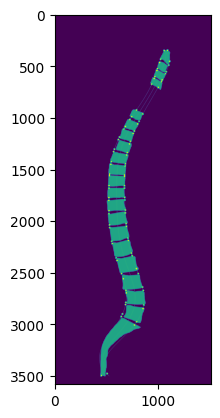

In [7]:
# point vertebras
IMG_PATH = os.path.join(DATA_DIR, 'test/IMG-0001-00001.png')
IMG_PATH_TRUE = os.path.join(DATA_DIR, 'test/IMG-0001-00001.png')

img = cv2.inRange(cv2.imread(IMG_PATH), (20, 20, 210), (40, 40, 240))
img_true = cv2.inRange(cv2.imread(IMG_PATH_TRUE), (20, 20, 210), (40, 40, 240))

data = np.array(img, dtype="float32") / 255
data_true = np.array(img_true, dtype="float32") / 255

# side_pad = (
#     int((IMG_SHAPE[0] - data.shape[0]) / 2),
#     int((IMG_SHAPE[1] - data.shape[1]) / 2)
# )

# data = np.pad(data, (
#     (side_pad[0], side_pad[0]),
#     (side_pad[1], side_pad[1]),
# ), 'constant', constant_values=0)

from func import search_for_borders, get_edgefunc_coef, get_vertebras_corners, get_ratio, approximateYbezie_lcr, adjast_vertebras, MSE

n = 10
threshold = 0.7 # gap < x < vertebra

border_coords = search_for_borders(data)
border_coords_true = search_for_borders(data_true)

edge_coef = get_edgefunc_coef(data, border_coords, n)
edge_coef_true = get_edgefunc_coef(data_true, border_coords_true, n)

y, y_l, y_r = approximateYbezie_lcr(border_coords, edge_coef, n)
y_true, y_l_true, y_r_true = approximateYbezie_lcr(border_coords_true, edge_coef_true, n)

vertebras_corners = get_vertebras_corners(data, border_coords, y, y_l, y_r, threshold)
vertebras_corners_true = get_vertebras_corners(data, border_coords_true, y_true, y_l_true, y_r_true, threshold)

#vertebras_corners = adjast_vertebras(border_coords, vertebras_corners, y, y_l, y_r)
#vertebras_corners_true = adjast_vertebras(border_coords_true, vertebras_corners_true, y_true, y_l_true, y_r_true) 
# It can't be used due to a huge size of S1 part

error = MSE(vertebras_corners, vertebras_corners_true)

vertebras_corners = [[[vertebras_corners[i], vertebras_corners[i + 1]], [vertebras_corners[i + 2], vertebras_corners[i + 3]]] for i in range(0, len(vertebras_corners), 4)]

print(len(vertebras_corners), '- vertebras')
for i in vertebras_corners:
    data = cv2.circle(data, (int(i[0][0][1]), int(i[0][0][0])), 5, 255, 5)
    data = cv2.circle(data, (int(i[0][1][1]), int(i[0][1][0])), 5, 255, 5)
    data = cv2.circle(data, (int(i[1][0][1]), int(i[1][0][0])), 5, 255, 5)
    data = cv2.circle(data, (int(i[1][1][1]), int(i[1][1][0])), 5, 255, 5)

for i in range(border_coords[0][1], border_coords[1][1] + 1):
    data[i, int(y[i - border_coords[0][1]])] = 200
    data[i, int(y_l[i - border_coords[0][1]])] = 200
    data[i, int(y_r[i - border_coords[0][1]])] = 200

data[data <= 1] *= 150

cv2.imwrite(os.path.join(DATA_DIR, 'test/SD_ver.png'), data)

plt.imshow(data)